# Entity Resolution project @ Wavestone
## Full pipeline Amazon-Google Products Matching

> *Datasets information from [here](https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/index.html)*

> **Tristan PERROT**


## Import libraries

In [ ]:
import os

import pandas as pd
import torch
import pickle
import time

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:1


In [33]:
while 'model' not in os.listdir():
    os.chdir('..')

from model.utils import load_data

In [ ]:
MODEL_NAME = ''
DATA_NAME = 'amazon-google'
DATA_DIR = os.path.join('data', DATA_NAME)

In [ ]:
table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(DATA_DIR, order_cols=False, remove_col_names=True)

Table A columns:
    column_name data_example
1   description          NaN
2  manufacturer   broderbund
3         price          0.0 

Table B columns:
    column_name              data_example
1   description  learning quickbooks 2007
2  manufacturer                    intuit
3         price                     38.99 

Serialized entities 



In [5]:
table_a_serialized[:5]

['clickart 950 000 - premier image pack (dvd-rom)  broderbund 0.0',
 "noah's ark activity center (jewel case ages 3-8)  victory multimedia 0.0",
 "peachtree by sage premium accounting for nonprofits 2007 peachtree premium accounting for nonprofits 2007 is the affordable easy to use accounting solution that provides you with donor/grantor management. if you're like most nonprofit organizations you're constantly striving to maximize each and every dollar of your annual operating budget. financial reporting by programs and funds advanced operational reporting and the rock-solid core accounting features that have made peachtree the choice of hundreds of thousands of small businesses. the result is an accounting solution tailor-made for the challenges of operating a nonprofit organization. keep an audit trail to record and report on any changes made to your transactions improve data integrity with prior period locking archive your organization's data for snap shots of your data before you c

## Blocking

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm, trange

def perform_blocking_sbert(model_name, table_a_serialized, table_b_serialized, n_neighbors=20, metric='cosine', device='cpu'):
    model = SentenceTransformer(model_name, device=device)
    table_a_embeddings = model.encode(table_a_serialized)
    table_b_embeddings = model.encode(table_b_serialized)

    knn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
    knn.fit(table_b_embeddings)

    return knn.kneighbors(table_a_embeddings, return_distance=False)

def get_blocking_metrics(indices, all_true_matches, len_table_a, len_table_b):
    n_m = len(all_true_matches)
    n_n = len_table_a * len_table_b - n_m
    s_m = 0
    s_n = 0

    for i in range(len(indices)):
        for j in indices[i]:
            if (i, j) in all_true_matches:
                s_m += 1
            else:
                s_n += 1
    
    reduction_ratio = 1 - (s_m + s_n) / (n_m + n_n)
    recall = s_m / n_m
    f1 = 2 * (reduction_ratio * recall) / (reduction_ratio + recall)

    return reduction_ratio, recall, f1

def perform_blocking_tfidf(table_a_serialized, table_b_serialized, n_neighbors=20, metric='cosine'):
    vectorizer = TfidfVectorizer()
    table_a_tfidf = vectorizer.fit_transform(table_a_serialized)
    table_b_tfidf = vectorizer.transform(table_b_serialized)

    knn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
    knn.fit(table_b_tfidf)

    return knn.kneighbors(table_a_tfidf, return_distance=False)

def merge_indices(indices1, indices2):
    merged_indices = []
    assert len(indices1) == len(indices2)
    for i in range(len(indices1)):
        merged_indices.append(list(set(indices1[i]) | set(indices2[i])))
    return merged_indices

In [7]:
all_true_matches = set()
for i in range(len(X_train_ids)):
    if y_train[i] == 1:
        all_true_matches.add((X_train_ids[i][0], X_train_ids[i][1]))
for i in range(len(X_valid_ids)):
    if y_valid[i] == 1:
        all_true_matches.add((X_valid_ids[i][0], X_valid_ids[i][1]))
for i in range(len(X_test_ids)):
    if y_test[i] == 1:
        all_true_matches.add((X_test_ids[i][0], X_test_ids[i][1]))

In [8]:
K_NEIGHBORS = 20
MODEL_NAME = 'multi-qa-mpnet-base-dot-v1'

sbert_indices = perform_blocking_sbert(MODEL_NAME, table_a_serialized, table_b_serialized, n_neighbors=K_NEIGHBORS, device=device)
tfidf = perform_blocking_tfidf(table_a_serialized, table_b_serialized, n_neighbors=K_NEIGHBORS)
merged_indices = merge_indices(sbert_indices, tfidf)

In [9]:
RR, PC, F1 = get_blocking_metrics(merged_indices, all_true_matches, len(table_a_serialized), len(table_b_serialized))
print(f'RR: {RR:.4f}, PC: {PC:.4f}, F1: {F1:.4f}')

RR: 0.9753, PC: 0.9908, F1: 0.9829


In [15]:
table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(DATA_DIR, order_cols=True, remove_col_names=False)

Table A columns:
    column_name data_example
1   description          NaN
2  manufacturer   broderbund
3         price          0.0 

Table B columns:
    column_name              data_example
1   description  learning quickbooks 2007
2  manufacturer                    intuit
3         price                     38.99 

Reordering columns
Table A columns order before: ['name' 'description' 'manufacturer' 'price']
Table B columns order before: ['name' 'description' 'manufacturer' 'price']
Table A columns order after: ['price' 'manufacturer' 'name' 'description']
Table B columns order after: ['price' 'manufacturer' 'name' 'description']
Serialized entities 



In [16]:
all_matches = []
for i in range(len(table_a_serialized)):
    for j in merged_indices[i]:
        all_matches.append((i, j))


In [17]:
# Import train test split
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into train and test sets
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(all_matches, [1 if x in all_true_matches else 0 for x in all_matches], test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train_knn, X_valid_knn, y_train_knn, y_valid_knn = train_test_split(X_train_knn, y_train_knn, test_size=0.2, random_state=42)

print(f'Train size: {len(X_train_knn)}, Validation size: {len(X_valid_knn)}, Test size: {len(X_test_knn)}')


Train size: 22755, Validation size: 5689, Test size: 7111


## Matching

In [18]:
import numpy as np
import torch.nn as nn
from sentence_transformers import CrossEncoder, InputExample
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss

In [19]:
len(table_a_serialized)

1113

In [20]:
table_a_serialized[0]

'[COL] price [VAL] 0.0 [COL] manufacturer [VAL] broderbund [COL] name [VAL] clickart 950 000 - premier image pack (dvd-rom) [COL] description [VAL] '

In [21]:
X_train = [(table_a_serialized[int(x[0])], table_b_serialized[int(x[1])]) for x in X_train_knn]
X_valid = [(table_a_serialized[int(x[0])], table_b_serialized[int(x[1])]) for x in X_valid_knn]
X_test = [(table_a_serialized[int(x[0])], table_b_serialized[int(x[1])]) for x in X_test_knn]
X_train[:5]

[('[COL] price [VAL] 59.95 [COL] manufacturer [VAL] core learning [COL] name [VAL] corefx three level [COL] description [VAL] corefx is suitable for beginners to advanced users of both computers and art and design. right from the opening page users will find the instructions and suggestions intuitive and very easy to use. corefx supplies a comprehensive set of artists tools which can be applied directly onto the page. charcoal felt tips coloring pencils and many more can be used individually or mixed and blended to create a limitless number of effects. it is this blending of colors which is unique and quite frankly dazzling! corefx allows you to work with images from a wide variety of sources. use digital photographs image scans web graphics and many other sources as your starting point. any images you produce in corefx can easily be saved for use on the web (including animations) and other software programs.',
  '[COL] price [VAL] 395.99 [COL] manufacturer [VAL]  [COL] name [VAL] core

In [22]:
final_table_exports = ""

In [23]:
X1_train, X2_train = [x[0] for x in X_train], [x[1] for x in X_train]
X1_valid, X2_valid = [x[0] for x in X_valid], [x[1] for x in X_valid]
X1_test, X2_test = [x[0] for x in X_test], [x[1] for x in X_test]

In [24]:
# Display the first 5 samples of the training set
for i in range(5):
    print(f'Sample {i}:')
    print(f'Entity1: {X1_train[i]}')
    print(f'Entity2: {X2_train[i]}')
    print(f'Label: {y_train_knn[i]}')
    print()

Sample 0:
Entity1: [COL] price [VAL] 59.95 [COL] manufacturer [VAL] core learning [COL] name [VAL] corefx three level [COL] description [VAL] corefx is suitable for beginners to advanced users of both computers and art and design. right from the opening page users will find the instructions and suggestions intuitive and very easy to use. corefx supplies a comprehensive set of artists tools which can be applied directly onto the page. charcoal felt tips coloring pencils and many more can be used individually or mixed and blended to create a limitless number of effects. it is this blending of colors which is unique and quite frankly dazzling! corefx allows you to work with images from a wide variety of sources. use digital photographs image scans web graphics and many other sources as your starting point. any images you produce in corefx can easily be saved for use on the web (including animations) and other software programs.
Entity2: [COL] price [VAL] 395.99 [COL] manufacturer [VAL]  [

In [25]:
train_datasets = [InputExample(texts=[X1_train[i], X2_train[i]], label=y_train_knn[i]) for i in range(len(X_train_knn))]
valid_datasets = [InputExample(texts=[X1_valid[i], X2_valid[i]], label=y_valid_knn[i]) for i in range(len(X_valid_knn))]
test_datasets = [InputExample(texts=[X1_test[i], X2_test[i]], label=y_test_knn[i]) for i in range(len(X_test_knn))]
train_loader = DataLoader(train_datasets, shuffle=True, batch_size=16, num_workers=0)
valid_loader = DataLoader(valid_datasets, shuffle=False, batch_size=16, num_workers=0)
test_examples = DataLoader(test_datasets, shuffle=False, batch_size=16, num_workers=0)

valid_evaluation_set = [(e1, e2) for e1, e2 in zip(X1_valid, X2_valid)]

In [26]:
EPOCHS = 3
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 200
CLASSIFIER_DROPOUT = None
threshold = 0.65

loss_fct = BCEWithLogitsLoss()

def callback(score, epoch, steps):
    print(f'Epoch {epoch} - Score {score} - Steps {steps}')

In [30]:
MODEL_NAME = 'cross-encoder/stsb-distilroberta-base'
OUTPUT_PATH = os.path.join('results-full', DATA_NAME, MODEL_NAME)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [31]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT, default_activation_function=nn.Sigmoid())

In [32]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid_knn, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            output_path=OUTPUT_PATH,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1423 [00:00<?, ?it/s]

Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 0 - Score 0.8274470569343297 - Steps -1


Iteration:   0%|          | 0/1423 [00:00<?, ?it/s]

Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 1 - Score 0.8522203907937723 - Steps -1


Iteration:   0%|          | 0/1423 [00:00<?, ?it/s]

Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 2 - Score 0.8822163214119554 - Steps -1


In [33]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
accuracy = np.mean(y_pred == y_test_knn)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test_knn, y_pred))

loss_fct = BCEWithLogitsLoss()
loss = loss_fct(torch.tensor(logits).float(), torch.tensor(y_test_knn).float())
print(f'Loss: {loss.item()}')

report = classification_report(y_test_knn, y_pred, output_dict=True)
final_table_exports += "| " + MODEL_NAME + f" | {report["accuracy"]:.3f} | {report["1"]["precision"]:.3f} | {report["1"]["recall"]:.3f} | {report["1"]["f1-score"]:.3f} | {loss.item():.6f} |\n"

Accuracy: 0.9845310082970047
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6860
           1       0.76      0.81      0.79       251

    accuracy                           0.98      7111
   macro avg       0.88      0.90      0.89      7111
weighted avg       0.99      0.98      0.98      7111

Loss: 0.6881652474403381


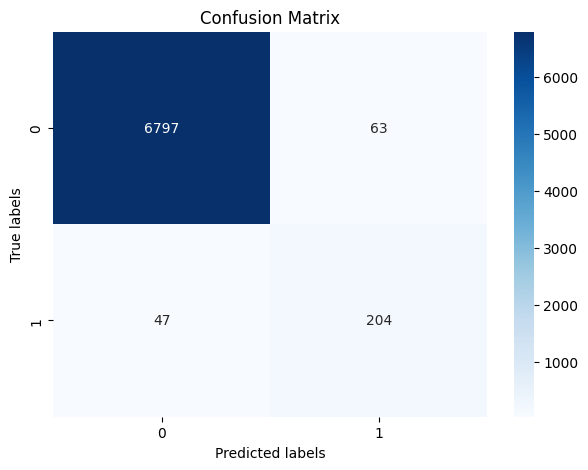

In [41]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_knn, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

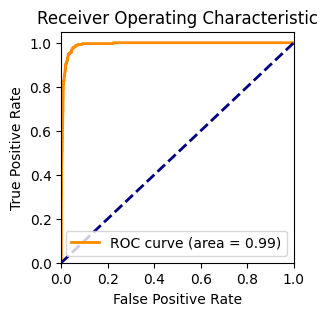

In [38]:
# ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test_knn, logits)
roc_auc = roc_auc_score(y_test_knn, logits)

plt.figure(figsize=(3, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()